# Assessing the Performance of Lolopy
Transferring data to and from JVM is remarkably costly. In this notebook, we quantify how costly the transfer is compared to the training as a function of training set size. We will use a standard ML problem: predicting glass-forming ability of ternary metallic alloys.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
from lolopy.learners import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor as SKRFRegressor
from sklearn.datasets import load_boston
from subprocess import PIPE, Popen
from time import perf_counter
import pandas as pd
import numpy as np

Make a timing function. 

In [2]:
def time_function(fun, n, *args, **kwargs):
    """Run a certain function and return timing
    
    Args:
        fun (function): Function to be evaluated
        n (int): Number of times to run function
        args: Input to function
    Returns:
        ([float]) Function run times
    """
    
    times = []
    for i in range(n):
        st = perf_counter()
        fun(*args, **kwargs)
        times.append(perf_counter() - st)
    return times

## Create the Dataset
We'll use the famous Boston Housing Prices dataset

In [3]:
X, y = load_boston(True)
print('Training set size:', X.shape)

Training set size: (506, 13)


Make a function to run the scala benchmark

In [4]:
def get_scala_timings(X, y, X_run):
    """Train a RF with standard settings using Lolo, generate uncertainties for whole dataset, report timings
    
    Args:
        X, y (ndarray): Training dataset
        X_run (ndarray): Dataset to evaluate
    Returns:
        train, apply (float): Training and uncertainty evaluation times
    """
    np.savetxt('train.csv', np.hstack((X, y[:, None])), delimiter=',')
    np.savetxt('run.csv', np.hstack((X_run, np.zeros((len(X_run), 1)))), delimiter=',')
    p = Popen('scala -cp ../../../target/lolo-1.0.2.jar scala-benchmark.scala train.csv run.csv', stdout=PIPE, 
         stderr=PIPE, shell=True)
    result = p.stdout.read().decode()
    train, apply = result.split(",")
    return float(train), float(apply)

In [5]:
scala_train, scala_apply = get_scala_timings(X, y, X)

In [6]:
print('Lolo train time:', scala_train)

Lolo train time: 4.66947575


In [7]:
print('Lolo apply time', scala_apply)

Lolo apply time 1.7720002222222224


## Profile Fitting the Model
We are looking to comprae the total time for fitting a model to the time required to send data over

In [8]:
model = RandomForestRegressor(num_trees=len(X))

Fit the model 16 times, measure the times

In [9]:
rf_fit = time_function(model.fit, 16, X, y)
print('Average fit time:', np.mean(rf_fit))

Average fit time: 11.851779124999666


Run only transfering the data to Java, record the time

In [10]:
rf_transfer = time_function(model._convert_train_data, 16, X, y)
print('Average transfer time:', np.mean(rf_transfer))

Average transfer time: 6.819827437499953


Compute uncertainities

In [11]:
rf_apply = time_function(model.predict, 16, X, return_std=True)
print('Average predict time:', np.mean(rf_apply))

Average predict time: 8.475267812497805


In [12]:
rf_apply_transfer = time_function(model._convert_run_data, 16, X)
print('Average transfer time for prediction:', np.mean(rf_apply_transfer))

Average transfer time for prediction: 6.4029486250001355


## Time Scikit-Learn
Compare against a scikit-learn model with the same amount of trees as Lolo.

*TODO*: Make sure the number of features evaluated are the same

In [13]:
sk_model = SKRFRegressor(n_estimators=len(X))

In [14]:
sk_train = time_function(sk_model.fit, 16, X, y)

In [15]:
print('Sklearn fitting time:', np.mean(sk_train))

Sklearn fitting time: 3.4027280000000246


## Compare as a Function of Scale
Measure the performance of each model as a function of training/test set size

In [16]:
results = []
for n in tqdm(np.logspace(1, np.log10(len(X)), 8, dtype=int)):
    # Initialize output
    r = {'n': n}
    
    # Get the training and test set sizes
    X_n = X[:n, :]
    y_n = y[:n]
    
    # Time using lolo via Scala
    scala_train, scala_apply = get_scala_timings(X_n, y_n, X)
    r['scala_train'] = scala_train
    r['scala_apply'] = scala_apply
    
    # Time using lolo via lolopy
    model = RandomForestRegressor(num_trees=int(n))
    
    r['lolopy_train'] = np.mean(time_function(model.fit, 16, X_n, y_n))
    r['lolopy_train_transfer'] = np.mean(time_function(model._convert_train_data, 16, X_n, y_n))
    
    r['lolopy_apply'] = np.mean(time_function(model.predict, 16, X, return_std=True))
    r['lolopy_apply_transfer'] = np.mean(time_function(model._convert_run_data, 16, X))
    
    # Time using RF
    sk_model = SKRFRegressor(n_estimators=n)
    
    r['sklearn_fit'] = np.mean(time_function(sk_model.fit, 16, X_n, y_n))
    r['sklearn_apply'] = np.mean(time_function(sk_model.predict, 16, X))
    
    # Append results and continue
    results.append(r)

HBox(children=(IntProgress(value=0, max=8), HTML(value='')))

In [17]:
results = pd.DataFrame(results)

In [18]:
results

,lolopy_apply,lolopy_apply_transfer,lolopy_train,lolopy_train_transfer,n,scala_apply,scala_train,sklearn_apply,sklearn_fit
0,6.449083,6.094587,0.465031,0.189455,10,0.044693,0.028032,0.003158,0.014075
1,6.906543,4.263141,0.572667,0.329949,17,0.051760,0.044725,0.002188,0.020421
2,5.854016,6.158963,0.827212,0.316315,30,0.056027,0.049215,0.004694,0.037431
3,8.932051,8.510031,1.603319,0.665952,53,0.109107,0.105836,0.009983,0.110930
4,2.738132,2.219114,2.274838,0.532986,94,0.269422,0.200021,0.007155,0.081229
5,2.397991,1.956030,1.314788,0.781743,164,0.179722,0.217633,0.014690,0.190337
6,3.684293,2.778427,2.649331,2.025648,288,0.385785,0.619048,0.025704,0.547062
7,4.586586,3.314806,6.342520,2.339271,506,1.109086,2.197706,0.085973,2.042719


Plot the training results

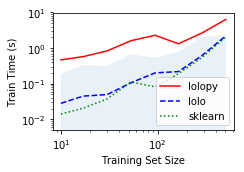

In [19]:
fig, ax = plt.subplots()

ax.fill_between(results['n'], results['lolopy_train_transfer'], 0.001, alpha=0.1)

ax.loglog(results['n'], results['lolopy_train'], 'r', label='lolopy')
ax.loglog(results['n'], results['scala_train'], 'b--', label='lolo')
ax.loglog(results['n'], results['sklearn_fit'], 'g:', label='sklearn')

ax.set_ylim(0.005, max(ax.get_ylim()))

ax.set_xlabel('Training Set Size')
ax.set_ylabel('Train Time (s)')

ax.legend()
fig.set_size_inches(3.5, 2.5)
fig.tight_layout()

Plot the evaluation speed

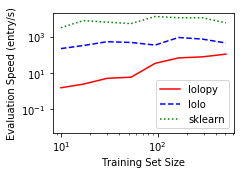

In [21]:
fig, ax = plt.subplots()

ax.loglog(results['n'], results['n']  / results['lolopy_apply'], 'r', label='lolopy')
ax.loglog(results['n'], results['n'] / results['scala_apply'], 'b--', label='lolo')
ax.loglog(results['n'], results['n'] / results['sklearn_apply'], 'g:', label='sklearn')

ax.set_ylim(0.005, max(ax.get_ylim()))

ax.set_xlabel('Training Set Size')
ax.set_ylabel('Evaluation Speed (entry/s)')

ax.legend()
fig.set_size_inches(3.5, 2.5)
fig.tight_layout()